# Variational Autoencoder
    Developed by: Christian Eger
    Würzburg Institute for Systems Immunology, Faculty of Medicine, Julius-Maximilian-Universität Würzburg
    Created: 240328
    Latest version: 240328

In [26]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import anndata as ad
import helper
from tqdm import tqdm
import scanpy as sc
import matplotlib.pyplot as plt

In [27]:
adata = ad.read_h5ad(
    '../data/Marburg_cell_states_locked_scANVI_ctl230901.raw.h5ad'
)
adata

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'mt', 'ribo'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [28]:
sc.pp.normalize_total(adata)

In [106]:
training_size, testing_size = helper.return_dataset_sizes(adata, 0.8, 0.25)

training_data, testing_data = helper.obs_to_tensor(adata, category=None, training_size=training_size, testing_size=testing_size)

training_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
testing_dataloader = DataLoader(testing_data, batch_size=64, shuffle=False)

## Model definition

In [30]:
class VAE(nn.Module):
    def __init__(self, data_size, latent_dim):
        super().__init__()
        # encoder
        self.fc_enc1 = nn.Linear(data_size, 5000)
        self.fc_enc2 = nn.Linear(5000, 1000)
        self.fc_enc3 = nn.Linear(1000, 200)

        # sampling distribution parameters
        self.fc_mu = nn.Linear(200, latent_dim)
        self.fc_logvar = nn.Linear(200, latent_dim)

        #decoder
        self.fc_dec1 = nn.Linear(latent_dim, 200)
        self.fc_dec2 = nn.Linear(200, 1000)
        self.fc_dec3 = nn.Linear(1000, 5000)
        self.fc_dec4 = nn.Linear(5000, data_size)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        sample = mu + (eps * std)
        return sample

    def forward(self, x):
        x = F.relu(self.fc_enc1(x))
        x = F.relu(self.fc_enc2(x))
        x = F.relu(self.fc_enc3(x))

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparametrize(mu, logvar)
        x = self.fc_dec1(z)

        x = F.relu(self.fc_dec2(x))
        x = F.relu(self.fc_dec3(x))
        x = F.relu(self.fc_dec4(x))
        return x, mu, logvar

In [49]:
def final_loss(bce_loss, mu, logvar):
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train(model, dataloader, optimizer, criterion, device):
    model.to(device)
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in enumerate(dataloader):
        counter += 1
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    training_loss = running_loss / counter
    return training_loss

def validate(model, dataloader, criterion, device):
    model.to(device)
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            counter += 1
            data = data.to(device)
            reconstruction, mu, logvar = model(data) 
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        validation_loss = running_loss / counter
        return validation_loss

## Model Training

In [32]:
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    print("Available CUDA devices:")
    for i in range(num_devices):
        print(f"  {i}: {torch.cuda.get_device_name(i)}")
    device = torch.device("cuda:1") 
    print(f"Using CUDA device: {device}")
    torch.cuda.set_device(device)
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")

Available CUDA devices:
  0: NVIDIA RTX 6000 Ada Generation
  1: NVIDIA RTX 6000 Ada Generation
Using CUDA device: cuda:1


In [115]:
data_size = training_data.shape[1]
model = VAE(
    data_size=data_size,
    latent_dim=64,
)
dataloader = training_data
optimizer = torch.optim.Adam(model.parameters(), lr=0.000005)
criterion = nn.BCEWithLogitsLoss()

In [116]:
epochs = 35
training_losses = []
validation_losses = []

for epoch in tqdm(range(epochs)):

    training_loss = train(
        model,
        training_dataloader,
        optimizer,
        criterion,
        device,
    )
    #print(f'Training loss = {training_loss}')
    training_losses.append(training_loss)

    validation_loss = validate(
        model,
        testing_dataloader,
        criterion,
        device,
    )
    #print(f'Validation loss = {validation_loss}')
    validation_losses.append(validation_loss)

100%|██████████| 35/35 [05:29<00:00,  9.42s/it]


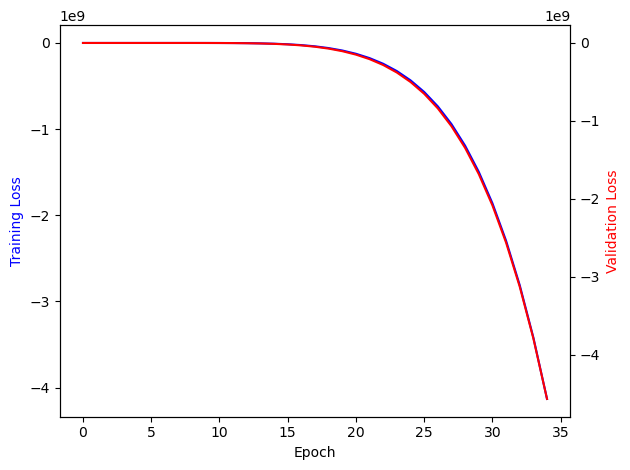

In [117]:
helper.plot_scaled_losses(training_losses, validation_losses, epochs)